# Training

In this notebook two neural networks are trained:
- a reference network using a squared error loss function
- a quantile regression neural network (QRNN)

## The Data


In [2]:
import utils.config
import numpy as np
import matplotlib.pyplot as plt
%env KERAS_BACKEND=tensorflow

x_train     = np.load("data/x_train.npy")
y_train     = np.load("data/y_train.npy")
x_val     = np.load("data/x_val.npy")
y_val     = np.load("data/y_val.npy")
cloud_types = np.load("data/cloud_types_train.npy")

env: KERAS_BACKEND=tensorflow


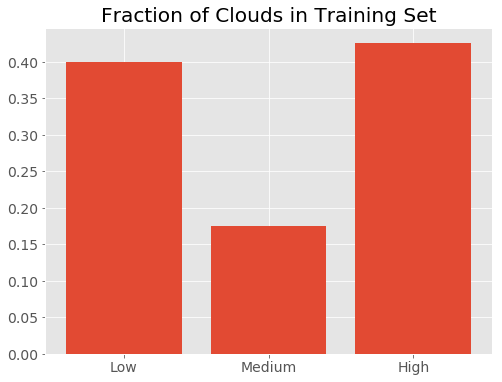

In [3]:
bins = np.array([-0.5, 0.5, 1.5, 2.5])
plt.hist(cloud_types, bins = bins, normed = True, rwidth = 0.8)
plt.title("Fraction of Clouds in Training Set")
plt.xticks([0, 1, 2])
plt.gca().xaxis.set_ticklabels(["Low", "Medium", "High"])

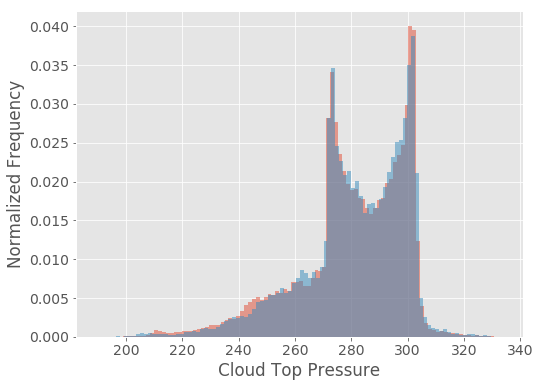

In [4]:
x_val = np.load("data/x_val.npy")
i = 1
plt.hist(x_train[:, i], normed = True, alpha = 0.5, bins = 101)
#plt.hist(y_val,  normed = True, alpha = 0.5, bins = 51)
plt.hist(x_val[:, i],  normed = True, alpha = 0.5, bins = 101)
plt.xlabel("Cloud Top Pressure")
plt.ylabel("Normalized Frequency")

## Training

In [8]:
adversarial_training = True
delta_at             = 0.05
ensemble_size        = 5
depth                = 4
width                = 64

filename = "models/qrnn_"
filename += str(depth) + "_" + str(width) + "_ensemble_" + str(ensemble_size)
if adversarial_training:
    filename += "_at_" + str(int(delta_at * 100))
filename    

'models/qrnn_4_64_ensemble_5_at_5'

In [9]:
from typhon.retrieval.qrnn import QRNN

n_input = x_train.shape[1]
quantiles = np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95])


adversarial_training = True
delta_at             = 0.05
ensemble_size        = 5
depth                = 4
width                = 64

filename = "models/qrnn_"
filename += str(depth) + "_" + str(width) + "_ensemble_" + str(ensemble_size)
if adversarial_training:
    filename += "_at_" + str(int(delta_at * 100))

qrnn_simple = QRNN(n_input, quantiles, depth = depth, width = width, ensemble_size = ensemble_size)
qrnn_simple.fit(x_train, y_train, sigma_noise = None,
                adversarial_training = adversarial_training,
                delta_at = delta_at,
                x_val = x_val,
                y_val = y_val,
                initial_learning_rate = 0.005,
                batch_size = 128,
                learning_rate_minimum = 1e-4,
                learning_rate_decay = 2,
                maximum_epochs = 500,
                training_split = 0.75,
                convergence_epochs = 0)
qrnn_simple.save(filename)

Epoch 1/500
26672/26672 [==============================] - 42s - loss: 446.6726 - val_loss: 369.6416
Epoch 2/500
26672/26672 [==============================] - 43s - loss: 381.6010 - val_loss: 350.2138
Epoch 3/500
26672/26672 [==============================] - 57s - loss: 368.5189 - val_loss: 344.4622
Epoch 4/500
26665/26672 [============================>.] - ETA: 0s - loss: 360.8175
 Reduced learning rate to 0.004999999888241291
26672/26672 [==============================] - 62s - loss: 360.8185 - val_loss: 350.1449
Epoch 5/500
26672/26672 [==============================] - 58s - loss: 335.2336 - val_loss: 334.6250
Epoch 6/500
26652/26672 [============================>.] - ETA: 0s - loss: 334.4981
 Reduced learning rate to 0.0024999999441206455
26672/26672 [==============================] - 50s - loss: 334.5008 - val_loss: 339.6164
Epoch 7/500
26672/26672 [==============================] - 56s - loss: 323.5872 - val_loss: 329.6815
Epoch 8/500
26658/26672 [============================>

26672/26672 [==============================] - 42s - loss: 381.4140 - val_loss: 376.5079
Epoch 3/500
26672/26672 [==============================] - 41s - loss: 344.9025 - val_loss: 336.3460
Epoch 4/500
26671/26672 [============================>.] - ETA: 0s - loss: 341.6482
 Reduced learning rate to 0.0024999999441206455
26672/26672 [==============================] - 41s - loss: 341.6479 - val_loss: 336.9249
Epoch 5/500
26672/26672 [==============================] - 41s - loss: 329.0950 - val_loss: 333.9471
Epoch 6/500
26638/26672 [============================>.] - ETA: 0s - loss: 327.7191
 Reduced learning rate to 0.0012499999720603228
26672/26672 [==============================] - 41s - loss: 327.7222 - val_loss: 343.6927
Epoch 7/500
26672/26672 [==============================] - 41s - loss: 322.1346 - val_loss: 332.1442
Epoch 8/500
26672/26672 [==============================] - 42s - loss: 319.9303 - val_loss: 331.8253
Epoch 9/500
26672/26672 [==============================] - 42s - 

## The Reference Model

We also fit an identical reference model, but training with a squared error loss function.

In [ ]:
ts = 0.9
n = x_train.shape[0]
n_train = round(ts * n)
n_val = n - n_train
inds  = np.random.permutation(n)
x_val_ref = x_train[inds[n_train:], :]
y_val_ref = y_train[inds[n_train:]]
x_train_ref = x_train[inds[:n_train], :]
y_train_ref = y_train[inds[:n_train]]

In [ ]:
from keras.models import Sequential, clone_model
from keras.optimizers import SGD
from keras.layers import Dense
from keras.losses import mean_squared_error
from typhon.retrieval.qrnn.qrnn import TrainingGenerator, ValidationGenerator, LRDecay

input_dim = 16
width = 64
activation = "relu"

model = Sequential()
model.add(Dense(input_dim = input_dim,
                units = width,
                activation = activation))
model.add(Dense( units = width,
                activation = activation))
model.add(Dense( units = width,
                activation = activation))
model.add(Dense(units = 1, activation = None))

          
x_mean  = x_train.mean(axis = 0, keepdims = True)
x_sigma = x_train.std(axis = 0, keepdims = True)

model.compile(loss = mean_squared_error,
              optimizer = SGD(lr = 0.00001))
training_generator   = TrainingGenerator(x_train_ref, x_mean, x_sigma, y_train_ref, None, 1024)
validation_generator = ValidationGenerator(x_val_ref, x_mean, x_sigma, y_val_ref, None)
lr_callback = LRDecay(model, 2.0, 1e-10, 2)
model.fit_generator(training_generator, steps_per_epoch = n_train // 1024,
                   epochs = 200, validation_data = validation_generator,
                    validation_steps = 1, callbacks = [lr_callback])



Epoch 1/200
2097/2097 [==============================] - 8s - loss: 30458.9484 - val_loss: 20238.3398
Epoch 2/200
2097/2097 [==============================] - 9s - loss: 19755.7136 - val_loss: 19288.4004
Epoch 3/200
2097/2097 [==============================] - 8s - loss: 18987.4007 - val_loss: 18812.6367
Epoch 4/200
2097/2097 [==============================] - 8s - loss: 18426.1289 - val_loss: 18535.4082
Epoch 5/200
2097/2097 [==============================] - 8s - loss: 17980.5546 - val_loss: 18849.2656
Epoch 6/200
2097/2097 [==============================] - 9s - loss: 17555.0626 - val_loss: 17848.9199
Epoch 7/200
2097/2097 [==============================] - 8s - loss: 17278.7663 - val_loss: 18054.2129
Epoch 8/200
2097/2097 [==============================] - 8s - loss: 17009.1203 - val_loss: 16953.8164
Epoch 9/200
2097/2097 [==============================] - 8s - loss: 16808.0857 - val_loss: 17514.4590
Epoch 10/200
2097/2097 [==============================] - 8s - loss: 16553.5989 - 

In [ ]:
model.save("models/mse")
np.save("models/mse_mean",  x_mean)
np.save("models/mse_sigma", x_sigma)